# Random Acts of Pizza (RAOP) Notes

**Source**: Althoff, T., Danescu-Niculescu-Mizil, C., & Jurafsky, D. (2014). *How to Ask for a Favor: A Case Study on the Success of Altruistic Requests*. Association for the Advancement of Artificial
Intelligence (www.aaai.org).

- "The community only publishes which users have given or received pizzas but not which requests were successful. 
In the case of successful users posting multiple times it is unclear which of the requests was actually successful. 
Therefore, we restrict our analysis to users with a single request for which we can be certain whether or not 
it was successful, leaving us with 5728 pizza requests. We split this dataset into development(70%) and test set (30%) 
such that both sets mirror the average success rate in our dataset of 24.6%. All features are developed on the 
development test only while the test set is used only once to evaluate the prediction accuracy of our proposed model on held-out data. For a small number of requests (379) we further observe the identity of the benefactor through a 
'thank you' post by the beneficiary after the successful request. This enables us to reason about the impact of 
user similarity on giving."


- "It is extremely difficult to disentangle the effects of all these factors in determining what makes people satisfy requests, and what makes them select some requests over others. . . In this paper, we develop a framework for controlling for each of these potential confounds while studying the role of two aspects that characterize compelling requests: **social factors** (who is asking and how the recipient is related to the donor and community) and **linguistic factors** (how they are asking and what linguistic devices accompany successful requests). With the notable exception of Mitra and Gilbert (2014), the effect of language on the success of requests has largely been ignored thus far."


- "[Their] goal is to understand what motivates people to give when they do not receive anything tangible in return. That is, [they] focus on the important special case of altruistic requests in which the giver receives no rewards." **DSC**: But how do you know people don't want something in return, especially if they are more likely to help requesters who have high status or are more similar to them?

-----

Temporal Factors
- Specific months
- Weekdays
- **Days of the month (first half of the month)**
- Hour of the day
- **Community age of the request (earlier the better)**

Textual Factors
- Politeness (e.g., **gratitude**)
- **Evidentiality** (2nd largest parameter estimate)
- Reciprocity (respond to a positive action with another positive action, **pay it forward**)
- Sentiment (e.g., **urgency**)
- **Length**

Social Factors
- **Status**
    - karma points (up-votes minus down-votes) that Reddit counts on link submissions and comments,
    - user has posted on RAOP before and thus could be considered a member of the sub-community. 
    - **user account age based on the hypothesis that “younger” accounts might be less trusted**


- Similarity: intersection size between the set of the giver and receiver, and the Jaccard similarity (intersection
over union) of the two. NOT included in logistic regression model.

Narratives (identified through topic modeling)
- **Desire**
- **Family**
- **Job**
- **Money**
- Student

-----

Conclusion
- Drawing from social psychology literature [they] extract high-level social features from text that operationalize the relation between recipient and donor and demonstrate that these extracted relations are predictive of success. 
- [They] show that [they] can detect key narratives automatically that have significant impact on the success of the request. 
- [They] further demonstrate that linguistic indications of gratitude, evidentiality, and reciprocity, as well as the high status of the asker, all increase the likelihood of success, while neither politeness nor positive sentiment seem to be associated with success in [the] setting.

Limitations
- A shortcoming of any case study is that findings might be specific to the scenario at hand. While [they] have shown that particular linguistic and social factors differentiate between successful and unsuccessful requests [they] cannot claim a causal relationship between the proposed factors and success that would guarantee success. 
- Furthermore, the set of success factors studied in this work is likely to be incomplete as well and excludes,
for instance, group behavior dynamics. 
- Despite these limitations, [they] hope that this work and the data [they] make available will provide a basis for further research on success factors and helping behavior in other online communities.

-----

In [117]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import codecs
import json
import csv

import re
import numpy as np
import pandas as pd
from numpy import *
from pandas import *
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [118]:
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html
# Convert a JSON string to pandas object

X = pd.read_json('./pizza_request_dataset.json')
print "type(X)", type(X)
print
#print X.head()
#print X.describe()
#print

# set random seed
np.random.seed(0)

# randomly assign 70% to train_data, and 30% to dev_data
msk = np.random.rand(len(X)) <= 0.7
train_data = X[msk]
dev_data = X[~msk]

# create output dataframe Y of train_labels
train_labels = train_data[["requester_received_pizza"]]

# delete train_labels from input dataframe of train_data
del train_data["requester_received_pizza"]

# create output dataframe of dev_labels
dev_labels = dev_data[["requester_received_pizza"]]
#Y.describe()

# delete dev_labels from input dataframe of dev_data
del dev_data["requester_received_pizza"]

# print labels, shapes, and feature names
print "train_labels" 
print "----------"
print list(train_labels)
print train_labels.shape
print
print "train_data" 
print "----------"
print list(train_data)
print train_data.shape
print

print "dev_labels" 
print "----------"
print list(dev_labels)
print dev_labels.shape
print
print "dev_data"
print "----------"
print list(dev_data)
print dev_data.shape
print

# print percent of train_data and dev_data whose posts led to receipt of pizza
print "train labels"
print "----------"
print np.mean(train_labels)
print
print "dev labels"
print "----------"
print np.mean(dev_labels)

type(X) <class 'pandas.core.frame.DataFrame'>

train_labels
----------
[u'requester_received_pizza']
(3975, 1)

train_data
----------
[u'giver_username_if_known', u'in_test_set', u'number_of_downvotes_of_request_at_retrieval', u'number_of_upvotes_of_request_at_retrieval', u'post_was_edited', u'request_id', u'request_number_of_comments_at_retrieval', u'request_text', u'request_text_edit_aware', u'request_title', u'requester_account_age_in_days_at_request', u'requester_account_age_in_days_at_retrieval', u'requester_days_since_first_post_on_raop_at_request', u'requester_days_since_first_post_on_raop_at_retrieval', u'requester_number_of_comments_at_request', u'requester_number_of_comments_at_retrieval', u'requester_number_of_comments_in_raop_at_request', u'requester_number_of_comments_in_raop_at_retrieval', u'requester_number_of_posts_at_request', u'requester_number_of_posts_at_retrieval', u'requester_number_of_posts_on_raop_at_request', u'requester_number_of_posts_on_raop_at_retrieval', u

In [119]:
# test function before use

data = ['A','B','C']
df = pd.DataFrame(data=data)
print df

df.shape

def to_np(d):
    
    # convert to numpy array
    print "numpy.ndarray:"
    d = array(d)
    # http://stackoverflow.com/questions/13730468/from-2d-to-1d-arrays
    d = d.flatten()
    print type(d)
    print d.shape
    print d[:3]
    return d

df = to_np(df)
df.shape

   0
0  A
1  B
2  C
numpy.ndarray:
<type 'numpy.ndarray'>
(3,)
['A' 'B' 'C']


(3,)

In [120]:
# prepare data
# transform X to numpy array, and Y to 1-D numpy array
# view actual text and labels

train_text = train_data["request_text"]
dev_text = dev_data["request_text"]

print "type(train_text)", type(train_text)
print "type(train_labels)", type(train_labels)
print "type(dev_text)", type(dev_text)
print "type(dev_labels)", type(dev_labels)
print

#from numpy import *

# view as pandas dataframe
print "pandas dataframe:"
print train_text[:10]
print

# convert to numpy (np) array

def to_np(d):

    print "numpy.ndarray:"
    d = array(d)
    # http://stackoverflow.com/questions/13730468/from-2d-to-1d-arrays
    d = d.flatten()
    print type(d)
    print d.shape
    print d[:3]
    print
    return d

train_text = to_np(train_text)
train_labels = to_np(train_labels)
dev_text = to_np(dev_text)
dev_labels = to_np(dev_labels)

# convert to list

def to_list(d):


    print "list:"
    d = list(d)
    print type(d)
    print d[:3]
    print 
    return d

#train_text = to_list(train_text)
#dev_text = to_list(dev_text)

print "train_labels.shape:", train_labels.shape
print "dev_labels.shape:", dev_labels.shape

type(train_text) <class 'pandas.core.series.Series'>
type(train_labels) <class 'pandas.core.frame.DataFrame'>
type(dev_text) <class 'pandas.core.series.Series'>
type(dev_labels) <class 'pandas.core.frame.DataFrame'>

pandas dataframe:
0     I'm not in College, or a starving artist or an...
2     I'm sure there are needier people on this subr...
3     I've been unemployed going on three months now...
4     I ran out of money on my meal card a while bac...
5                                                      
6     Hi amazing people! I've known of this subreddi...
9     So it's finals week and I haven't eaten all da...
11    I'll write a poem, sing a song, do a dance, pl...
12              Thank you so much for the pizza Trisha!
14    Hi RAoP\n\nAs the title suggests, I have been ...
Name: request_text, dtype: object

numpy.ndarray:
<type 'numpy.ndarray'>
(3975,)
[ u"I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lately. I'm a 36 year old s

In [121]:
import operator
# http://stackoverflow.com/questions/209840/map-two-lists-into-a-dictionary-in-python
# http://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary

# Notes
# Classifier precision--when a positive value is predicted, proportion of time the prediction is correct--equals (TP) / (TP + FP)
# Classifier recall--when the actual value is positive, the proportion of time the prediction is correct--equals (TP) / (TP + FN)

def explore_models():
### STUDENT START ###

    # create empty vector
    accuracies = []

    # Source: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    # The F1 score can be interpreted as a weighted average of the precision and recall, 
    # where an F1 score reaches its best value at 1 and worst score at 0. 
    # The relative contribution of precision and recall to the F1 score are equal. 
    # The formula for the F1 score is: F1 = 2 * (precision * recall) / (precision + recall)
    
    vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
    #vectorizer = CountVectorizer(min_df=1, stop_words='english')
    train_vectors = vectorizer.fit_transform(train_text)
    print "train_vectors.shape:", train_vectors.shape
    
    dev_vectors = vectorizer.transform(dev_text)
    print "dev_vectors.shape:", dev_vectors.shape
    print
    
    #------------------------
    # K Nearest Neighbors
    #------------------------
    
    print "------------------------------"
    print "K Nearest Neighbors (K-NN)"
    print "------------------------------"
    
    # Euclidean distance, when you go to 10 to 20+ dimensions, too many examples can be close to each other
    # With K-NN on text, Cosine or Manhattan distance might be better. Cosine distance measures the angle between examples,
    # more robust for high-dimensional problems. 
    # Dot product measures length of vectors AND angle between these vectors. 
    # With Cosine distance, you can get a value 0 to 1.
    
    # create two vectors
    # ks refers to a vector of k nearest neighbor values
    
    ks = [1, 5, 15, 16, 17, 18, 19, 20, 28, 29, 30, 31, 32, 150, 300]
    f1_scores = []
    
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, distance='cosine', algorithm='brute')
        knn.fit(train_vectors, train_labels)
        pred_1 = knn.predict(dev_vectors)
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
        # f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)[source]¶
            # y_true = Ground truth (correct) target values 
            # y_pred = Estimated targets as returned by a classifier.
            # average = required for multiclass/multilabel targets.
                # 'weighted': Calculate metrics for each label, and find their average, weighted by 
                # the number of true instances for each label. This alters ‘macro’ to account for label imbalance; 
                # it can result in an F-score that is not between precision and recall.
            
        print "K-NN: f1_score = %s, k = %s" % (round(metrics.f1_score(dev_labels, pred_1, average='binary'),4), k)

        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_1))
    
    print
    
    # map two vectors into a dictionary
    results_knn = dict(zip(ks, f1_scores))
    #print results_knn
    
    # print the key with the max fl_score
    print "K-NN: optimal k =", max(results_knn.iteritems(), key=operator.itemgetter(1))[0]
    print

    #------------------------
    # Bernoulli Naive Bayes
    #------------------------
    
    print "-----------------------------"
    print "Bernoulli Naive Bayes (BNB)"
    print "-----------------------------"
    
    # create two vectors
    
    alphas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.094, 0.095, 0.096, 0.1, 0.105, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 10.0]
    f1_scores = []
    
    for a in alphas:
        bnb = BernoulliNB(alpha=a,binarize=0.5)
        bnb.fit(train_vectors, train_labels)
        pred_2 = bnb.predict(dev_vectors)
        print "BNB: f1_score = %s, alpha = %s" % (round(metrics.f1_score(dev_labels, pred_2, average='binary'), 4), a)
        
        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_2))
        
    print
    
    # map two vectors into a dictionary
    results_bnb = dict(zip(alphas, f1_scores))
    #print results_mnb
    
    # print the key with the max fl_score
    print "Bernoulli Naive Bayes: optimal alpha =", max(results_bnb.iteritems(), key=operator.itemgetter(1))[0]
    print
    
    #------------------------
    # Logistic Regression
    #------------------------
    
    print "------------------------"
    print "Logistic Regression (LR)"
    print "------------------------"
    print
    
    # create two vectors
    # cs refers to the vector of C (inverse of regularization strength) values
    
    cs = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, \
          10, 12, 20, 30, 40, 50, 100, 1000]
    f1_scores = []
    
    for c in cs:
        
        # logistic regression fits a line like linear regression, but instead of predicting any number, 
        # it predicts a number between 0 and 1 (sigmoid function).
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
        # C (inverse of regularization strength) controls how much the weights influence the loss, and
        # penalizes the sum of squared weights if very different weights exist between different tokens.
  
        # use l2 regularization, per instructions
        lr = LogisticRegression(penalty='l2',C=c)
        lr.fit(train_vectors, train_labels)
        pred_3 = lr.predict(dev_vectors)
        
        print "-------------------------------"
        print "LR: f1_score = %s, C = %s" % (round(metrics.f1_score(dev_labels, pred_3, average='binary'),4), c)
        print "-------------------------------"
        
        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_3, average='binary'))
        
        accuracies.append((lr.score(dev_vectors, dev_labels))*100) 

        #print lr.coef_.shape
        
        # first define function that squares a given value, for later use in the 'for loop' below
        fun_sq_wts = lambda x: x**2
        
        # use map function, likely faster (because written in C) than list comprehension.
        # map function itself applies a function, specifically the first argument on the second argument.
        # from coef_, take raw weights (coefficient of the features in the decision function), 
        # and sum the squares of these weights.

        # note: averege=weight vs. average=default should be about same score if similar number of examples across classes
        sq_wts = map(fun_sq_wts, lr.coef_[0])
        sum_sq_wts = round(sum(sq_wts),2)
        print "Label = 1, sum of squared weights = %s" % (sum_sq_wts)

        print
        
    # map two vectors into a dictionary
    results_lr = dict(zip(cs, f1_scores))
    #print results_lr
    
    # print the key with the max fl_score
    print "Logistic Regression: optimal C =", max(results_lr.iteritems(), key=operator.itemgetter(1))[0]
    print
    print "max accuracy =", max(accuracies)
        
### STUDENT END ###

explore_models()

train_vectors.shape: (3975, 12313)
dev_vectors.shape: (1696, 12313)

------------------------------
K Nearest Neighbors (K-NN)
------------------------------
K-NN: f1_score = 0.4133, k = 1
K-NN: f1_score = 0.0259, k = 5
K-NN: f1_score = 0.0, k = 15
K-NN: f1_score = 0.0, k = 16
K-NN: f1_score = 0.0, k = 17
K-NN: f1_score = 0.0, k = 18
K-NN: f1_score = 0.0, k = 19
K-NN: f1_score = 0.0, k = 20
K-NN: f1_score = 0.0, k = 28
K-NN: f1_score = 0.0, k = 29
K-NN: f1_score = 0.0, k = 30
K-NN: f1_score = 0.0, k = 31
K-NN: f1_score = 0.0, k = 32
K-NN: f1_score = 0.0, k = 150
K-NN: f1_score = 0.0, k = 300

K-NN: optimal k = 1

-----------------------------
Bernoulli Naive Bayes (BNB)
-----------------------------
BNB: f1_score = 0.0, alpha = 0.0
BNB: f1_score = 0.0844, alpha = 1e-05
BNB: f1_score = 0.0844, alpha = 0.0001
BNB: f1_score = 0.0844, alpha = 0.001
BNB: f1_score = 0.0125, alpha = 0.01
BNB: f1_score = 0.0126, alpha = 0.094
BNB: f1_score = 0.0126, alpha = 0.095
BNB: f1_score = 0.0126, alpha 

/Users/dschan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


In [122]:
from pandas import *
from sklearn.feature_selection import SelectFromModel

# Feature Selection Notes:
'''
http://scikit-learn.org/stable/datasets/twenty_newsgroups.html
http://scikit-learn.org/stable/modules/feature_selection.html
http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#example-text-document-classification-20newsgroups-py

These objects take as input a scoring function that returns univariate p-values:
-For regression: f_regression
-For classification: chi2 or f_classif

Feature selection with sparse data:
-If you use sparse data (i.e. data represented as sparse matrices), 
only chi2 will deal with the data without making it dense.
-Warning: Beware not to use a regression scoring function with a classification problem, 
you will get useless results.

With SVMs and logistic-regression, the parameter C controls the sparsity: 
the smaller C the less features selected. 
'''

def top20(type):
### STUDENT START ###

    if type == "unigram":
        
        # use stop_words='english' to remove less meaningful words. 
        # only applies if default analyzer='word'.
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
        #vectorizer = CountVectorizer(min_df=1, stop_words='english')
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print "----------"
        print "unigram"
        print "----------"
        print
        print "train_vectors.shape:", train_vectors.shape
        print
        
    elif type == "bigram":
        
        # use stop_words='english' to remove less meaningful words from the resulting tokens. 
        # only applies if default analyzer='word'.
        # set bigrams to be 2 words only
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        #vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print "----------"
        print "bigram"
        print "----------"
        print
        print "train_vectors.shape:", train_vectors.shape
        print
      
    # use C=12
    for c in [12]:
        
        # in the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the default ‘multi_class’ option is set to ‘ovr’ 
        lr = LogisticRegression(penalty='l2',C=c)
        #print lr
        
        # fit the model and generate coef_
        lr.fit(train_vectors, train_labels)
         
        # interested in magnitude of the weights (coefficients), so take absolute value.
        # sort absolute values in descending order.
        # important to know if negative or positive weight, so still output the positive/negative sign.
        # after fitting logistic regression for class vs. all other classes, negative weight of a token 
        # indicates a class other than class of interest.
        # (visual example of negative and positive on a sigmoid function helps) 
        
        print "lr.coef_:"
        print lr.coef_
        print
        
        # for each label, store the column indices of the top 5 weights 
        top20 = sorted(range(len(lr.coef_[0])), key=lambda i: abs(lr.coef_[0][i]), reverse=True)[:20]
       
        col_1 = []
        
        # for each label, access and store weights via column indices
        for index in (top20):

            col_1.append(lr.coef_[0][index])
           
        print "top 20:" 
        print top20
        print
        
        # store feature names, after converting to an array
        feature_names = np.asarray(vectorizer.get_feature_names())
       
        # create a Pandas dataframe with 20 rows and 4 columns, plus descriptive headers
        df = DataFrame({'Feature': feature_names[top20], 'word': col_1})
        print df    

#-----
         
### STUDENT END ###
top20("unigram")
top20("bigram")


----------
unigram
----------

train_vectors.shape: (3975, 12313)

lr.coef_:
[[-1.48092905 -0.39311615 -0.12825177 ...,  0.44453487  1.63180069
  -0.87946286]]

top 20:
[3697, 4147, 6786, 8221, 1039, 6858, 3236, 1286, 6712, 10159, 1523, 10688, 4918, 10689, 9907, 7050, 3901, 2573, 2155, 9349]

       Feature      word
0         edit  4.824324
1       father  4.627494
2         mean  4.376547
3      pockets  4.057164
4          ass  3.995387
5    mentioned  3.977975
6          die  3.930683
7        basic  3.899384
8      married  3.850098
9     southern -3.846223
10       bloke  3.807984
11    surprise  3.805289
12   graveyard  3.749854
13   surprised  3.697465
14     sitting -3.697393
15       mommy  3.658543
16  especially  3.627059
17  constantly  3.593246
18      cheesy  3.548595
19     running  3.539010

----------
bigram
----------

train_vectors.shape: (3975, 90693)

lr.coef_:
[[-0.31775435  0.42001296 -0.29407174 ..., -0.26401881 -0.22234693
   0.57766744]]

top 20:
[23002, 389

-----------------
C =  0.01
-----------------
LR L1 regularization: f1_score = 0.0
LR L2 regularization: f1_score = 0.0

LR L1 regularization: number of non-zero weights = 0
LR L2 regularization: number of non-zero weights = 12313

LR L1 regularization: accuracy = 74.12%
LR L2 regularization: accuracy = 74.12%

-----------------
C =  0.03
-----------------
LR L1 regularization: f1_score = 0.0
LR L2 regularization: f1_score = 0.0

LR L1 regularization: number of non-zero weights = 0
LR L2 regularization: number of non-zero weights = 12313

LR L1 regularization: accuracy = 74.12%
LR L2 regularization: accuracy = 74.12%

-----------------
C =  0.05
-----------------
LR L1 regularization: f1_score = 0.0
LR L2 regularization: f1_score = 0.0

LR L1 regularization: number of non-zero weights = 0
LR L2 regularization: number of non-zero weights = 12313

LR L1 regularization: accuracy = 74.12%
LR L2 regularization: accuracy = 74.12%

-----------------
C =  0.07
-----------------
LR L1 regulariz

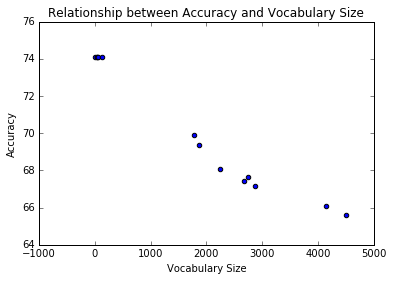

In [123]:
# define function fs (feature selection)

def fs():
    # Keep this random seed here to make comparison easier.
    
    # create two empty vectors
    accuracies = []
    vocab_size = []
    
    ### STUDENT START ###

    ### Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size.
    ### For this size, the default regularization, L2, computes the sum of the squared weights (see P3, above), while 
    ### L1 regularization computes the sum of the absolute values of the weights. 
    ### L2 regularization makes all the weights relatively small, whereas
    ### L1 regularization drives lots of the weights to 0, effectively removing unimportant features [for feature selection].

    ### http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html
     
    # set min_df=10 to ignore words that appear in less than 10 documents
    # use stop_words='english' to remove less meaningful words from the resulting tokens, only applies if default analyzer='word'.

    vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
    #vectorizer = CountVectorizer(min_df=1, stop_words='english')
    train_vectors = vectorizer.fit_transform(train_text)
    dev_vectors = vectorizer.transform(dev_text)    
    
    cs = [0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.57, 0.7, 1, 10, 12, 30, 50, 70, 100, 200, 300]
    # no longer use np.linspace to return evenly spaced numbers over a specified interval.
    # it offers less control.
    
    for c in cs:

        # fit l1 and l2 models
        lr_l1 = LogisticRegression(C=c, penalty='l1', tol=0.01)
        lr_l2 = LogisticRegression(C=c, penalty='l2', tol=0.01)
        lr_l1.fit(train_vectors, train_labels)
        lr_l2.fit(train_vectors, train_labels)
        
        # store predictions
        pred_l1 = lr_l1.predict(dev_vectors)
        pred_l2 = lr_l2.predict(dev_vectors)
        
        print "-----------------"
        print "C = ", round(c,3)
        print "-----------------"
        
        print "LR L1 regularization: f1_score = %s" % (round(metrics.f1_score(dev_labels, pred_l1, average='binary'),4))
        print "LR L2 regularization: f1_score = %s" % (round(metrics.f1_score(dev_labels, pred_l2, average='binary'),4))
        print
        
        #print "lr_l1.coef_:", lr_l1.coef_
        #print "lr_l2.coef_:", lr_l2.coef_
        
        # take mean weight for each class
        # axis=0 refers to mean of each column across 4 rows in coef_
        # use as definition of sparsity
        vec1 = np.mean(lr_l1.coef_, axis=0)
        vec2 = np.mean(lr_l2.coef_, axis=0)
        
        #print "vec1:", vec1
        #print "vec2:", vec2
        
        print "LR L1 regularization: number of non-zero weights =", (vec1 != 0).sum()
        print "LR L2 regularization: number of non-zero weights =", (vec2 != 0).sum()
        print 
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score
        # score(X, y, sample_weight=None)
        # Returns the mean accuracy on the given dev or test data and labels
        # In multi-label classification, this is the subset accuracy which is a harsh metric 
        # since you require for each sample that each label set be correctly predicted.
        
        print "LR L1 regularization: accuracy = %.2f%%" % ((lr_l1.score(dev_vectors, dev_labels))*100)
        print "LR L2 regularization: accuracy = %.2f%%" % ((lr_l2.score(dev_vectors, dev_labels))*100)
        print
        
        #print "recheck", train_vectors.shape
        #print "recheck", train_labels.shape
        
        #---------------
        # re-train model
        #---------------
        
        # likely no need to use fit_transform again, as we still have our vocabulary in matrix format with token counts.
        # we simply select non-zero weighted features (from columns), and leave documents (from rows) as is.
        
        # first, only select features that have non-zero weights from L1 regularization.
        # vec1 includes weights for each feature (column).
        train_vectors_rt = train_vectors[:, vec1 != 0]
        dev_vectors_rt = dev_vectors[:, vec1 != 0]
        
        #print train_vectors_rt
        
        #print "recheck", train_vectors_rt.shape
        #print "recheck", train_labels.shape
        
        lr_l2_rt = LogisticRegression(C=c, penalty='l2', tol=0.1)
    
        # refit our classifier to the model, so it can learn from the model
        # if the number of features >= 1 from L1 for L2
        if train_vectors_rt.shape[1] >= 1:
        
            lr_l2_rt.fit(train_vectors_rt, train_labels)
            pred_l2_rt = lr_l2_rt.predict(dev_vectors_rt)

            # take mean weight for each class
            # axis=0 refers to mean of each column across 4 rows in coef_
            # use as definition of sparsity
            vec_rt = np.mean(lr_l2_rt.coef_, axis=0)

            # append to vectors
            # note: try .score method (mean accuracy on the given test data and labels) rather than f1_score method,
            #        partly because sometimes the output cell shows a system automated warning about the f1_score
            accuracies.append((lr_l2_rt.score(dev_vectors_rt, dev_labels))*100)  
            vocab_size.append(train_vectors_rt.shape[1])

            print "***Re-trained model w/ L1 non-zero features***" 
            print "LR L2 regularization: f1_score = %s" % (round(metrics.f1_score(dev_labels, pred_l2_rt, average='binary'),4))
            print "LR L2 regularization: number of non-zero weights:", (vec_rt != 0).sum()
            print "LR L2 regularization: accuracy = %.2f%%" % ((lr_l2_rt.score(dev_vectors_rt, dev_labels))*100)
            print
            print "LR L2 regularization: vocab size:", (train_vectors_rt.shape[1])
            print

        #print accuracies
        #print vocab_size
        #print
    
    plt.scatter(vocab_size, accuracies)
    plt.ylabel('Accuracy')
    plt.xlabel('Vocabulary Size')
    plt.title('Relationship between Accuracy and Vocabulary Size')

    ### STUDENT END ###
fs()

In [124]:
# define function fs2 (feature selection, method 2)

def fs2():
    
    ### STUDENT START ###
    
    # CountVectorizer:
    # Tokenize the documents and count the occurrences of token and return them as a sparse matrix

    # TfidfTransformer:
    # Apply Term Frequency Inverse Document Frequency normalization to a sparse matrix of occurrence counts
    
    # Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency
    # This is a common term weighting scheme in information retrieval, 
    # that has also found good use in document classification.
    # The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to 
    # scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically 
    # less informative than features that occur in a small fraction of the training corpus.

    vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
    
    # apply the CountVectorizer fit_transform method -- which includes two methods in one -- on the train_text.
    # learn the vocabulary dictionary (all tokens from the raw documents) and return a matrix, 
    # extracting token counts to the cells.
    train_vectors = vectorizer.fit_transform(train_text)
    
    # apply the transform method to the dev_text
    dev_vectors = vectorizer.transform(dev_text)
    
    # transform train_text to matrix and print count of rows and columns
    # 2034 documents, 3064 words
    print "vocabulary size:", train_vectors.toarray().shape[1] 
    print
    
    lr = LogisticRegression(penalty='l2', C=100)
    lr.fit(train_vectors, train_labels)
    pred_4 = lr.predict(dev_vectors)

    # for each documents, store and print predicted probabilities that it belongs to each class
    
    # use the method, predict_proba
    
    # for each document in dev_vectors, get their probability estimates for all classes 
    p = lr.predict_proba(dev_vectors)
    print p

    # create an empty vector
    
    p_max_rates = []
    R_rates = []
    
    # iterate over each row (document) of p
    for i, p_docs in enumerate(p):
        # p_docs is a 1x2 vector from p with a document's probability to each class on one row
        # take the document's probability of the correct label
        p_correct_class = p_docs[dev_labels[i]]
        # take the document's max probability across the 4 labels
        p_max = p_docs.max()

        p_max_rates.append(p_max)
        
        # calculate R
        R = p_max / p_correct_class

        # append to the R_rates vector
        R_rates.append(R)

    # create vector that have indices of top 3 R_rates
    top3_index = sorted(range(dev_vectors.shape[0]), key=lambda i: R_rates[i], reverse=True)[:3]
    print "************************************************"
    print
    print "dev indices of top 3 R_rates:", top3_index
    print

    adhoc_label = ['False','True']
    
    for i in top3_index:
        
        # find index of max probability within each row
        # np.argmax returns the indices of the maximum values along an axis
        index_max_prob = np.argmax(p[i,:])
                                   
        print "---------------------------------------------------------------------"
        print "W207 Results"
        print "------------"
        print "R_rate:", R_rates[i]
        print "label probabilities:", p[i,:]
        print "Max probability dev_label -> %s" % (adhoc_label[index_max_prob])
        print "Correct dev_label -> %s" % (dev_labels[i])
        print "dev_text below:"
        print "---------------------------------------------------------------------"
        print
        print dev_text[i]
        print

    # create vector that have indices of bottom 3 R_rates
    bottom3_index = sorted(range(dev_vectors.shape[0]), key=lambda i: R_rates[i])[:3]
    print "************************************************"
    print
    print "dev indices of bottom 3 R_rates:", bottom3_index
    print
    
    for i in bottom3_index:
        
        # find index of max probability within each row
        # np.argmax returns the indices of the maximum values along an axis
        index_max_prob = np.argmax(p[i,:])
                                   
        print "---------------------------------------------------------------------"
        print "W207 Results"
        print "------------"
        print "R_rate:", R_rates[i]
        print "label probabilities:", p[i,:]
        print "Max probability dev_label -> %s" % (adhoc_label[index_max_prob])
        print "Correct dev_label -> %s" % (dev_labels[i])
        print "dev_text below:"
        print "---------------------------------------------------------------------"
        print
        print dev_text[i]
        print
        
        
    ### STUDENT END ###
fs2()

vocabulary size: 12313

[[ 0.21100575  0.78899425]
 [ 0.99503696  0.00496304]
 [ 0.93736369  0.06263631]
 ..., 
 [ 0.98865797  0.01134203]
 [ 0.48297265  0.51702735]
 [ 0.18677316  0.81322684]]
************************************************

dev indices of top 3 R_rates: [469, 1221, 489]

---------------------------------------------------------------------
W207 Results
------------
R_rate: 10665.5317861
label probabilities: [  9.99906249e-01   9.37511855e-05]
Max probability dev_label -> False
Correct dev_label -> True
dev_text below:
---------------------------------------------------------------------

Hi first time posting here , I'm extremely hungry right now haven't eaten much today except junk food because there isn't much food at home I like.

I have a decent amount of allergies one of them being soy sauce but my mom still made Stir Fry which has it in it , No she is not a horrible person I just don't like getting heartburn anymore so I generally don't eat it. Fun Fact : I am

/Users/dschan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
